In [34]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

Import the dataframes: 

In [35]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_absolute_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_relative_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_sampledata_5in10.tsv', sep= ' ', index_col=0, header=0)

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [36]:
index = target.Lake[target.Lake == 'Muskegon'].index

In [37]:
'''Set sample names as index and shuffle data'''

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
#data_abs = data_abs.sample(frac=1, random_state=3)
#data_rel = data_rel.sample(frac=1, random_state=3)
#target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [38]:
#Some variables to store information and to create inner and outer CV-folds
otus = list(data_rel.columns)
cv = 5

In [39]:
''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_rel,otus)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

**Univariate Feature Selection**: 

Let's compare two methods: 
- f_regression (f-score pearson correlation), 
- Mutual information,  
- (other methods can follow as well). 

In [40]:
f_regr, f_regr_p = f_regression(data_stand.loc[:,otus],hna)
kendall = np.zeros(len(otus))
p_kendall = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    kendall[i], p_kendall[i] = kendalltau(data_stand.loc[:,otus[i]],hna)
uni_fs = pd.DataFrame(f_regr, index=otus, columns = ['f_regr'])
uni_fs['p-value'] = f_regr_p
uni_fs['kendall'] = kendall
uni_fs['p_kendall'] = p_kendall
display(uni_fs.head(10))

,f_regr,p-value,kendall,p_kendall
Otu000001,2.375606,0.128502,-0.142819,0.100998
Otu000004,0.460889,0.499819,0.048174,0.580413
Otu000005,14.624381,0.000315,0.263340,0.002916
Otu000006,0.768060,0.384313,-0.036796,0.678248
Otu000007,5.385262,0.023725,0.169988,0.051852
Otu000009,3.439108,0.068586,0.162606,0.062188
Otu000010,1.329067,0.253544,-0.095920,0.271513
Otu000011,0.390347,0.534486,0.071466,0.412181
Otu000012,17.576741,0.000092,-0.347920,0.000067
Otu000014,0.385016,0.537281,0.055312,0.583662


Select otu's based on $p < \text{thr}$: 

In [41]:
print('Total OTUs: ' + str(len(otus)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_kendall'].values < 0.05]
print('Number of selected OTUs using Kendall tau with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_kendall'].values < 0.01]
print('Number of selected OTUs using Kendall tau with p < 0.01: ' + str(len(uni_fs_selected_f)))

Total OTUs: 482
Number of selected OTUs using Kendall tau with p < 0.05: 112
Number of selected OTUs using Kendall tau with p < 0.01: 58


What happens when we tune a threshold in function of the f_score: 

In [42]:
from analysis_functions import get_r2_scores
thr_otu_kendall_hna, r2_otu_kendall_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.abs(uni_fs['kendall']), cv)
thr_otu_kendall_lna, r2_otu_kendall_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.abs(uni_fs['kendall']), cv)

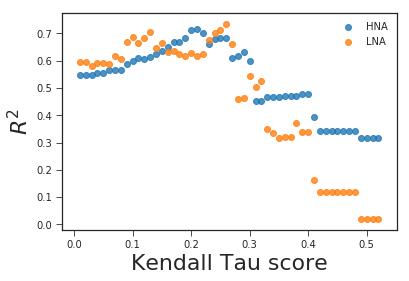

In [43]:
plt.figure()
sns.regplot(x=thr_otu_kendall_hna,y=r2_otu_kendall_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_kendall_lna,y=r2_otu_kendall_lna, fit_reg=False, label='LNA')
plt.xlabel('Kendall Tau score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
#plt.title('F-test', size=24)
plt.legend()
plt.show()

In [44]:
from analysis_functions import get_lassoCV_alpha

alpha = get_lassoCV_alpha(data_stand.loc[:,otus],hna,otus,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores, cv)
thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


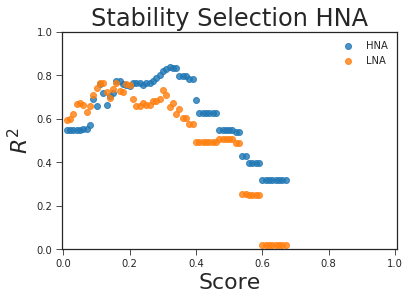

In [45]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection HNA', size=24)
plt.show()

In [46]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.837448007611
Threshold score: 0.32


In [47]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores['kendall'] = uni_fs.loc[otu_scores.index,'kendall']
otu_scores['p_kendall'] = uni_fs.loc[otu_scores.index,'p_kendall']
otu_scores.to_csv('Final/hnascores_otus_5seq10_rel_Muskegon.csv')

In [48]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
otu_scores_selected.to_csv('Final/hnascores_otus_tuned_thr_'+str(thr)+'_5seq10_rel_Muskegon.csv')
display(otu_scores_selected.head(10))
print('Size list selected OTUs: ' + str(len(selected_otus)))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,kendall,p_kendall
Otu000173,0.662,19183.863568,1.389539,0.002640,1.213961,0.518860,5.505006e-09
Otu000905,0.584,1722.747677,1.597538,0.000223,1.367060,0.298122,2.275539e-03
Otu000242,0.548,4279.004838,1.331277,0.000632,1.054300,0.210994,2.225148e-02
Otu000060,0.528,45526.565552,1.078545,0.006393,0.679089,0.391586,8.120894e-06
Otu000059,0.502,29773.174200,0.587921,0.005351,0.567443,-0.209356,1.716857e-02
Otu000262,0.456,3251.883741,1.341030,0.000560,1.179736,-0.278675,2.716768e-03
Otu000067,0.454,18018.297795,1.504764,0.002812,1.239631,0.253386,4.355647e-03
Otu000075,0.396,29602.794740,1.086868,0.005599,1.224831,-0.262832,2.874675e-03
Otu000682,0.388,3564.311795,2.276817,0.000388,2.010094,0.213340,2.986646e-02
Otu000030,0.386,14053.072785,2.083508,0.001631,1.803059,0.210760,2.183005e-02


Size list selected OTUs: 17


In [49]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.65548226379


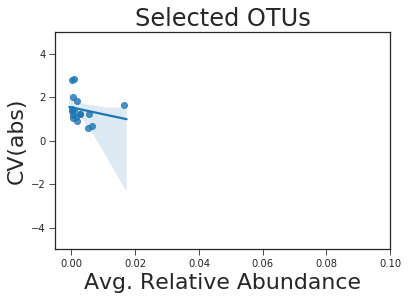

In [50]:
plt.figure()
sns.regplot(x='abun_rel_mean',y='abun_rel_CV', data=otu_scores_selected)
plt.axis([-0.005,0.1,-5,5])
plt.xlabel('Avg. Relative Abundance', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.title('Selected OTUs', size=24)
plt.show()

In [51]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [52]:
f_regr_lna, f_regr_p_lna = f_regression(data_stand.loc[:,otus],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p_lna
kendall = np.zeros(len(otus))
p_kendall = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    kendall[i], p_kendall[i] = kendalltau(data_stand.loc[:,otus[i]],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p
uni_fs_lna['kendall'] = kendall
uni_fs_lna['p_kendall'] = p_kendall
#uni_fs_lna['mi'] = mutual_info_regression(data_stand.loc[:,otus],lna)
#uni_fs_lna.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs_lna.head(10))

,f_regr,p-value,kendall,p_kendall
Otu000001,9.060537,0.128502,0.260249,2.803474e-03
Otu000004,2.774170,0.499819,0.152991,7.916713e-02
Otu000005,47.158471,0.000315,0.600069,1.182470e-11
Otu000006,1.026206,0.384313,0.230518,9.351038e-03
Otu000007,1.725742,0.023725,0.065871,4.511850e-01
Otu000009,1.085503,0.068586,0.078920,3.653921e-01
Otu000010,3.174153,0.253544,0.187070,3.199335e-02
Otu000011,0.035718,0.534486,0.042880,6.226932e-01
Otu000012,4.404077,0.000092,-0.164413,5.964701e-02
Otu000014,0.415074,0.537281,0.261002,9.707396e-03


In [53]:
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_kendall'].values < 0.05]
print('Number of selected OTUs using kendall tau with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_kendall'].values < 0.01]
print('Number of selected OTUs using kendall tau with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs using kendall tau with p < 0.05: 249
Number of selected OTUs using kendall tau with p < 0.01: 175


In [54]:
thr_otu_kendall_lna, r2_otu_kendall_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.absolute(uni_fs_lna['kendall']), cv)
thr_otu_kendall_hna, r2_otu_kendall_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.absolute(uni_fs_lna['kendall']), cv)

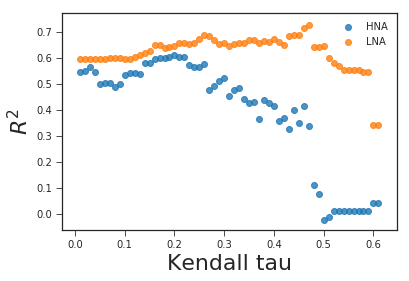

In [55]:
plt.figure()
sns.regplot(x=thr_otu_kendall_hna,y=r2_otu_kendall_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_kendall_lna,y=r2_otu_kendall_lna, fit_reg=False, label='LNA')
plt.xlabel('Kendall tau', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
#plt.title('Spearman correlation', size=24)
plt.legend()
plt.show()

In [56]:
alpha = get_lassoCV_alpha(data_stand.loc[:,otus],lna,otus,cv)
otu_scores_lna = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores_lna.sort_values(ascending=False, inplace=True, by='score')

thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores_lna, cv)
thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores_lna, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


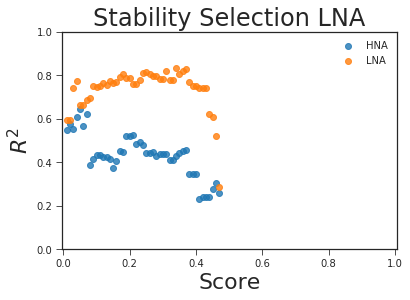

In [57]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection LNA', size=24)
plt.show()

In [58]:
r2_final = r2_otu_scores_lna.max()
thr_lna = thr_otu_scores_lna[r2_otu_scores_lna.argmax()]
print('R²_cv(lna): ' + str(r2_final) )
print('Threshold score: ' + str(thr_lna))

R²_cv(lna): 0.834858804857
Threshold score: 0.34


In [59]:
otu_scores_lna = otu_scores_lna.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores_lna =  otu_scores_lna.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores_lna['kendall'] = uni_fs_lna.loc[otu_scores.index,'kendall']
otu_scores_lna['p_kendall'] = uni_fs_lna.loc[otu_scores.index,'p_kendall']
otu_scores_lna.to_csv('Final/lnascores_otus_5seq10_rel_Muskegon.csv')

In [60]:
otu_scores_selected_lna = otu_scores_lna[otu_scores_lna.score.values>thr_lna]
selected_otus_lna = otu_scores_selected_lna.index
print('Size list selected OTUs: ' + str(len(selected_otus_lna)))
otu_scores_selected_lna.to_csv('Final/lnascores_otus_tuned_thr_'+str(thr_lna)+'_5seq10_rel_Muskegon.csv')
display(otu_scores_selected_lna.head(10))

Size list selected OTUs: 15


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,kendall,p_kendall
Otu000060,0.470,45526.565552,1.078545,0.006393,0.679089,0.393720,7.247488e-06
Otu000005,0.458,141867.570712,1.880070,0.016488,1.618859,0.600069,1.182470e-11
Otu000027,0.442,23380.093722,1.188701,0.005822,1.371008,-0.589278,2.380213e-11
Otu000682,0.434,3564.311795,2.276817,0.000388,2.010094,0.461275,2.654267e-06
Otu000029,0.428,61707.245500,1.200677,0.008522,0.878843,0.455449,1.972852e-07
Otu000030,0.402,14053.072785,2.083508,0.001631,1.803059,0.506625,3.534715e-08
Otu000409,0.400,1178.854171,2.146924,0.000341,2.593669,-0.307494,1.926958e-03
Otu000905,0.392,1722.747677,1.597538,0.000223,1.367060,0.416855,1.980417e-05
Otu000669,0.380,2348.435435,1.075879,0.000456,1.098500,-0.223773,1.727216e-02
Otu000048,0.368,22992.540565,1.451475,0.002952,1.165769,0.513073,1.181956e-08


In [61]:
print('R²_cv of LNA-selected OTUs in function of HNA: ' + str(r2_otu_scores_hna[r2_otu_scores_lna.argmax()]) )

R²_cv of LNA-selected OTUs in function of HNA: 0.429685599714


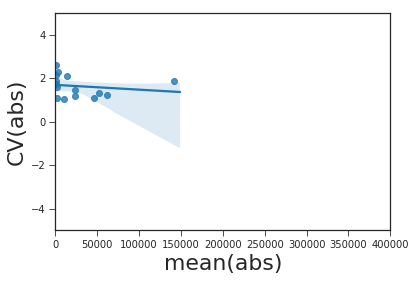

In [62]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=otu_scores_selected_lna)
plt.axis([0,400000,-5,5])
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [63]:
idx_hna = otu_scores_selected.index.difference(otu_scores_selected_lna.index)
idx_lna = otu_scores_selected_lna.index.difference(otu_scores_selected.index)
idx_common = otu_scores_selected.drop(idx_hna).index
pd.Series(idx_common).to_csv('commonOTU_HNALNA_rel.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(otu_scores_selected)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(otu_scores_selected_lna)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(otu_scores_selected_lna.loc[idx_common,:])
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 12; opposed to total size: 17
Size subset OTUs only related to LNA: 10; opposed to total size: 15
Size subset OTUs related to both: 5


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,kendall,p_kendall
Otu000905,0.392,1722.747677,1.597538,0.000223,1.367060,0.416855,1.980417e-05
Otu000060,0.470,45526.565552,1.078545,0.006393,0.679089,0.393720,7.247488e-06
Otu000682,0.434,3564.311795,2.276817,0.000388,2.010094,0.461275,2.654267e-06
Otu000030,0.402,14053.072785,2.083508,0.001631,1.803059,0.506625,3.534715e-08
Otu000005,0.458,141867.570712,1.880070,0.016488,1.618859,0.600069,1.182470e-11


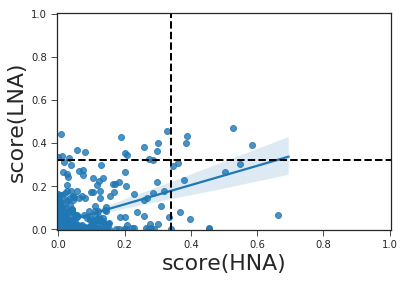

In [64]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=otu_scores_lna.loc[otu_scores.index,'score'])
plt.axis([-0.005,1.005,-0.005,1.005])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.axhline(y=thr, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.show()

This figure shows 4 area's: 
- (left top corner): OTU's selected solely in function of **LNA**-dynamics, 
- (right top corner): OTU's selected in function of both **HNA**- and **LNA**-dynamics, 
- (left bottom corner): OTU's that are _not_ selected, 
- (right bottom corner): OTU's selected solely in function of **HNA**-dynamics. 

Univariate vs. Stability selection

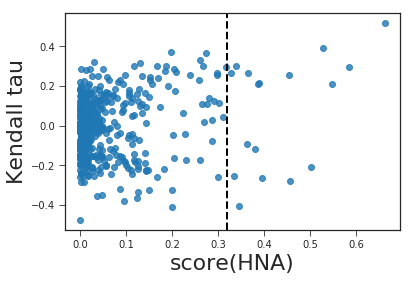

In [65]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=uni_fs.loc[otu_scores.index,'kendall'], fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau', size=22)
plt.yticks(size=10)
#plt.yscale('log')
#plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

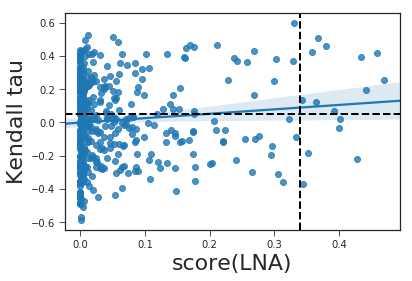

In [66]:
plt.figure()
sns.regplot(x=otu_scores_lna.loc[:,'score'],y=uni_fs_lna.loc[otu_scores.index,'kendall'])
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau', size=22)
plt.yticks(size=10)
#plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; this is also clear from the mutual correlation between HNA- and LNA-counts ( $\rho(\text{HNA,LNA}) = 0.75$ ). 

I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 